In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
import math
import pickle
import matplotlib.patches as mpatches
from tqdm import tqdm
from scipy import stats
import regex as re
from collections import Counter
from fuzzywuzzy import process
from thefuzz import fuzz


dat_path = os.getcwd()[:-12] + 'Data/'
fig_path = os.getcwd()[:-4] + 'figures/preliminary/'
generated_dat_path = os.getcwd()[:-12] + 'Data/generated_data/'

text_font = 30

In [2]:
norm_quant = 'Runs'
odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

odi_final.columns

Index(['search_ID', 'Match_ID', 'Match_Date', 'Venue', 'Team', 'Overs', 'Runs',
       'Wickets', 'player_name', 'bat_pos', 'bat_run', 'bat_balls',
       'bat_fours', 'bat_sixes', 'bat_wicket', 'bowl_overs', 'bowl_maiden',
       'bowl_runs', 'bowl_wickets', 'captain', 'wicketkeeper', 'PoM', 'Winner',
       'Batting_Order', 'renormalized_bat_run', 'renormalized_runs',
       'renormalized_bowl_runs', 'team_match_num', 'batsmen', 'bowler',
       'allrounder', 'opp_wickets'],
      dtype='object')

In [3]:
def axis_decor(ax, text_font, major_length, minor_length, linewidth):

    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

    ax.tick_params(axis='both', which='major', labelsize=text_font, length=major_length, width=linewidth)
    ax.tick_params(axis='both', which='minor', labelsize=text_font, length=minor_length, width=linewidth)

In [4]:
def openers_non_openers_data(min_career, norm_quant, batsmen_pos_threshold, pos_min_threshold):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])
    odi_final = odi_final.sort_values(by=['Match_ID','Team'])

    players_list = np.unique(odi_final['player_name'])

    openers_run, openers_strike = [], []
    non_openers_run, non_openers_strike = [], []

    openers_balls, non_openers_balls = [], []

    for players in tqdm(players_list):
        player_df = odi_final[odi_final['player_name'] == players]
        player_df = player_df.reset_index(drop=True)

        if len(player_df) >= min_career:

            openers_ind = np.where(player_df['bat_pos'] < 3)[0]
            non_openers_ind = np.where((3 <= player_df['bat_pos']) & (player_df['bat_pos'] <= batsmen_pos_threshold))[0]

            if len(openers_ind) > pos_min_threshold:
                openers_run.append(np.nanmean(player_df.iloc[openers_ind]['renormalized_bat_run']))
                openers_strike.append(np.nanmean(player_df.iloc[openers_ind]['renormalized_bat_run']/player_df.iloc[openers_ind]['bat_balls']))
                openers_balls.append(np.nanmean(player_df.iloc[openers_ind]['bat_balls']))

            if len(non_openers_ind) > pos_min_threshold:
                non_openers_run.append(np.nanmean(player_df.iloc[non_openers_ind]['renormalized_bat_run']))
                non_openers_strike.append(np.nanmean(player_df.iloc[non_openers_ind]['renormalized_bat_run']/player_df.iloc[non_openers_ind]['bat_balls']))
                non_openers_balls.append(np.nanmean(player_df.iloc[non_openers_ind]['bat_balls']))

    print(np.nanmean(openers_balls), np.average(non_openers_balls))

    with open(generated_dat_path + f'openers_non_openers_min_career_{min_career}_renorm_{norm_quant}_batsmen_pos_threshold_{batsmen_pos_threshold}_pos_min_threshold_{pos_min_threshold}.pkl', 'wb') as f:
        pickle.dump([openers_run, openers_strike, openers_balls, non_openers_run, non_openers_strike, non_openers_balls], f)

# openers_non_openers_data(min_career=25, norm_quant='Runs', batsmen_pos_threshold=6, pos_min_threshold=10)

In [11]:
def openers_non_openers_plot(min_career, norm_quant, batsmen_pos_threshold, pos_min_threshold):

    with open (generated_dat_path + f'openers_non_openers_min_career_{min_career}_renorm_{norm_quant}_batsmen_pos_threshold_{batsmen_pos_threshold}_pos_min_threshold_{pos_min_threshold}.pkl', 'rb') as f:
        openers_run, openers_strike, openers_balls, non_openers_run, non_openers_strike, non_openers_balls = pickle.load(f)

    fig, ax = plt.subplots(2,1, figsize=(10, 5))
    ax = ax.flatten()

    openers_strike = np.array(openers_strike)*100
    non_openers_strike = np.array(non_openers_strike)*100

    ind_problem = np.where(non_openers_strike > 125)[0]
    openers_strike = np.delete(openers_strike, ind_problem)
    non_openers_strike = np.delete(non_openers_strike, ind_problem)

    color_list = ['#55A8AE', '#CFAF4E']

    ##strike rate
    ax[0].scatter(openers_strike, np.random.uniform(2,3, len(openers_strike)), color=color_list[0], s=70, alpha=0.6, marker='o')
    ax[0].scatter(non_openers_strike, np.random.uniform(0,1, len(non_openers_strike)),  color=color_list[1], s=70, alpha=0.6, marker='o')
    ax[0].set_ylabel('strike-rate', fontsize=text_font, labelpad=20)
    ax[0].yaxis.set_label_coords(0.02, 0.42)
    ax[0].vlines(np.nanmean(openers_strike), 1.7, 3.3, color='black', linewidth=4, linestyle='-')
    ax[0].vlines(np.nanmean(non_openers_strike), -0.3, 1.3, color='black', linewidth=4, linestyle='-')
    ax[0].set_ylim(-0.5, 3.5)
    ax[0].set_xticks([40, 60, 80, 100])
    ax[0].spines['bottom'].set_bounds(40, 100)


    ##runs
    ax[1].scatter(openers_run, np.random.uniform(2,3, len(openers_run)), color=color_list[0], s=70, alpha=0.6, marker='o')
    ax[1].scatter(non_openers_run, np.random.uniform(0,1, len(non_openers_run)), color=color_list[1], s=70, alpha=0.6, marker='o')
    ax[1].set_ylabel('runs', fontsize=text_font, labelpad=20)
    ax[1].yaxis.set_label_coords(0.02, 0.42)
    ax[1].vlines(np.nanmean(openers_run), 1.7, 3.3, color='black', linewidth=4, linestyle='-')
    ax[1].vlines(np.nanmean(non_openers_run), -0.3, 1.3, color='black', linewidth=4, linestyle='-')
    ax[1].set_ylim(-0.5, 3.5)
    ax[1].set_xticks([10, 20, 30, 40, 50])
    ax[1].spines['bottom'].set_bounds(10, 50)
    
    
    

    print(np.nanmean(openers_run), np.nanmean(non_openers_run))
    print(np.nanmean(openers_strike), np.nanmean(non_openers_strike))

    print((np.nanmean(openers_run) - np.nanmean(non_openers_run))/np.nanmean(non_openers_run))
    print((np.nanmean(openers_strike) - np.nanmean(non_openers_strike))/np.nanmean(openers_strike))

    for axi in ax:
        axis_decor(axi, text_font, 10, 5, 3)  
        axi.set_yticks([])
        axi.set_yticklabels([])
        axi.spines['left'].set_visible(False)

    ax[0].scatter([],[], color=color_list[0], s=200, alpha=1, marker='o', label='openers')
    ax[0].scatter([],[], color=color_list[1], s=200, alpha=1, marker='o', label='non-openers')

    fig.legend(fontsize=text_font, loc='upper center', frameon=False, bbox_to_anchor=(0.35, 0.95, 0.2, 0.2), labelspacing=0.1, handletextpad=-0.4, columnspacing=0.1, ncol=2)

    plt.tight_layout()
    plt.savefig(fig_path + f'openers_non_openers_min_career_{min_career}_renorm_{norm_quant}_batsmen_pos_threshold_{batsmen_pos_threshold}_pos_min_threshold_{pos_min_threshold}.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()

# openers_non_openers_plot(min_career=25, norm_quant='Runs', batsmen_pos_threshold=6, pos_min_threshold=10)

In [6]:
def all_rounders_data(min_career, norm_quant):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final = odi_final.sort_values(by=['Match_ID','Team'])

    players_list = np.unique(odi_final['player_name'])

    all_rounder_contri, batsman_contri, bowler_contri = [], [], []

    for player in tqdm(players_list):
        player_df = odi_final[odi_final['player_name'] == player]

        if player_df['allrounder'].sum() >= min_career:
            for i in range(len(player_df)):
                tc = 0
                if (player_df.iloc[i]['renormalized_runs'] > 0) and (~np.isnan(player_df.iloc[i]['renormalized_bat_run'])):
                    tc += player_df.iloc[i]['renormalized_bat_run']/player_df.iloc[i]['renormalized_runs']
                if (player_df.iloc[i]['opp_wickets'] > 0) and (~np.isnan(player_df.iloc[i]['bowl_wickets'])):
                    tc += player_df.iloc[i]['bowl_wickets']/player_df.iloc[i]['opp_wickets']
                all_rounder_contri.append(0.5*tc)

        elif player_df['batsmen'].sum() >= min_career:
            for i in range(len(player_df)):
                if (player_df.iloc[i]['renormalized_runs'] > 0): 
                    if (~np.isnan(player_df.iloc[i]['renormalized_bat_run'])):
                        batsman_contri.append(0.5*(player_df.iloc[i]['renormalized_bat_run']/player_df.iloc[i]['renormalized_runs']))
                    else:
                        batsman_contri.append(0)


        elif player_df['bowler'].sum() >= min_career:
            for i in range(len(player_df)):
                if (player_df.iloc[i]['opp_wickets'] > 0): 
                    if(~np.isnan(player_df.iloc[i]['bowl_wickets'])):
                        bowler_contri.append(0.5*(player_df.iloc[i]['bowl_wickets']/player_df.iloc[i]['opp_wickets']))
                    else:
                        bowler_contri.append(0)

                    if bowler_contri[-1] > 1:
                        print(player, player_df.iloc[i]['bowl_wickets'], player_df.iloc[i]['opp_wickets'])
                        break


    with open(generated_dat_path + f'all_rounders_contribution_min_career_{min_career}_renorm_{norm_quant}.pkl', 'wb') as f:
        pickle.dump([all_rounder_contri, batsman_contri, bowler_contri], f)

# all_rounders_data(min_career=25, norm_quant='Runs')

0.10730404007642348 0.09711492364121678 0.06345982531790796


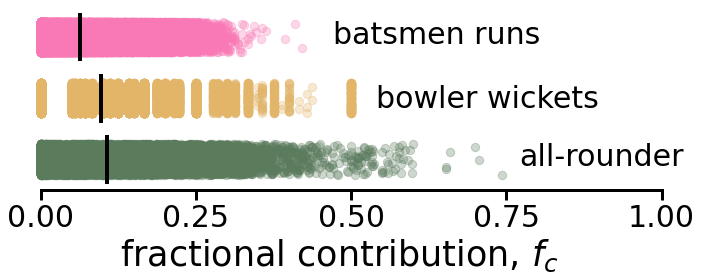

In [7]:
def all_rounders_plot(min_career, norm_quant):
    
    with open(generated_dat_path + f'all_rounders_contribution_min_career_{min_career}_renorm_{norm_quant}.pkl', 'rb') as f:
        all_rounder_contri, batsman_contri, bowler_contri = pickle.load(f)

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    batsman_contri = np.array(batsman_contri)#*2
    bowler_contri = np.array(bowler_contri)#*2
    all_rounder_contri = np.array(all_rounder_contri)

    # batsman_contri = batsman_contri[batsman_contri > 0]
    # bowler_contri = bowler_contri[bowler_contri > 0]
    # all_rounder_contri = all_rounder_contri[all_rounder_contri > 0]


    color_list = ['#5B7B5D', '#E2B569', '#F979B6']

    ax.scatter(all_rounder_contri, np.random.uniform(0,1, len(all_rounder_contri)), color=color_list[0], s=70, alpha=0.3, marker='o')

    ax.scatter(bowler_contri, np.random.uniform(2,3, len(bowler_contri)), color=color_list[1], s=70, alpha=0.3, marker='o')

    ax.scatter(batsman_contri, np.random.uniform(4,5, len(batsman_contri)), color=color_list[2], s=70, alpha=0.3, marker='o')

    ax.vlines(np.nanmean(all_rounder_contri), -0.3, 1.3, color='black', linewidth=4, linestyle='-')
    ax.vlines(np.nanmean(bowler_contri), 1.7, 3.3, color='black', linewidth=4, linestyle='-')
    ax.vlines(np.nanmean(batsman_contri), 3.7, 5.3, color='black', linewidth=4, linestyle='-')

    print(np.nanmean(all_rounder_contri), np.nanmean(bowler_contri), np.nanmean(batsman_contri))

    ax.text(0.77, 0.3, 'all-rounder', fontsize=text_font)
    ax.text(0.54, 2.2, 'bowler wickets', fontsize=text_font)
    ax.text(0.47, 4.3, 'batsmen runs', fontsize=text_font)
    
    ax.set_ylim(-0.5, 5.5)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.spines['bottom'].set_bounds(0,1)

    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)

    ax.set_xlabel(rf'fractional contribution, $f_c$', fontsize=text_font+5)

    axis_decor(ax, text_font, 10, 5, 3)

    plt.tight_layout()
    plt.savefig(fig_path + f'all_rounders_contribution_min_career_{min_career}_renorm_{norm_quant}.png', format='png', dpi=200)
    plt.show()
    plt.close()

# all_rounders_plot(min_career=25, norm_quant='Runs')

In [8]:
def get_fielder_name(name_str):

    exception_name = ['deSilva', 'tenDoeschate','vanderWath','deLeede','vanBunge', 'vanderMerwe', 'deLange','vanMeekeren', 'vanBeek', 'vanderGugten', 'vanBunge', 'vanTrost', 'duPlessis', 'deGrandhomme', 'deVilliers', 'vanLingen', 'vanTroost', 'vanJaarsveld', 'vanVuuren', 'vanRooi','deGrooth', 'deKock', 'vanderDussen']
    exception_pattern = '|'.join(exception_name)  # creates a pattern like 'deSilva|tenDoeschate|vanderWath|...'

    weird_outs = ['notout', 'runout', 'retiredhurt', 'obstructingfield', 'handledball', 'retiredill', 'retiredout']

    name = re.split('b(?=[A-Z])', name_str)

    if len(name) > 1:
        temp_name = name[0].replace('c', '').replace('st','').replace('†', '')
        if temp_name == '&':
            temp_name = name[1].replace('c', '').replace('st','').replace('†', '').replace('b', '').replace('&', '')

    elif len(name) == 1:
        name = re.split('b(?=' + exception_pattern + ')', name_str)

        if len(name) > 1:
            temp_name = name[0].replace('c', '').replace('st','').replace('†', '')
            if temp_name == '&':
                temp_name = name[1].replace('c', '').replace('st','').replace('†', '').replace('b', '').replace('&', '')
        else:
            if name[0] in weird_outs:
                return None
            else:
                return None
    else:
        return None

    return temp_name
    

In [32]:
def wicketkeepers_data(min_career, norm_quant):
    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final = odi_final.sort_values(by=['Match_ID','Team'])

    match_id_list = np.unique(odi_final['Match_ID'])

    wicketkeepers_data, fielders_data = {}, {}
    career_length = {}

    final_wicketkeepers_data, final_fielders_data = [], []

    
    for match_id in tqdm(match_id_list):
        match_df = odi_final[odi_final['Match_ID'] == match_id]

        for i in range(len(match_df)):
            if str(match_df.iloc[i]['bat_wicket']) != 'nan':

                name = get_fielder_name(match_df.iloc[i]['bat_wicket'])

                if name == None:
                    continue

                if ('†' in match_df.iloc[i]['bat_wicket']):
                    
                    try:
                        wicketkeepers_data[name] += 1
                    except:
                        wicketkeepers_data[name] = 1

                    mask = match_df['player_name'].str.contains(name)
                    filtered_df = match_df[mask]

                    if len(filtered_df) < 1:
                        ratios = [(n, fuzz.partial_ratio(name, n)) for n in match_df['player_name']]
                        best_match, max_ratio = max(ratios, key=lambda x: x[1])
                        player_df = odi_final[odi_final['player_name'] == best_match]
                        career_length[name] = len(player_df['Match_ID'])
                    
                    else:
                        player_df = odi_final[odi_final['player_name'] == filtered_df.iloc[0]['player_name']]
                        career_length[name] = len(player_df['Match_ID']) 


                else:
                    if match_df.iloc[i]['bat_wicket'][0] == 'c':
                        
                        try:
                            fielders_data[name] += 1
                        except:
                            fielders_data[name] = 1

                        mask = match_df['player_name'].str.contains(name)
                        filtered_df = match_df[mask]

                        if len(filtered_df) < 1:
                            ratios = [(n, fuzz.partial_ratio(name, n)) for n in match_df['player_name']]
                            best_match, max_ratio = max(ratios, key=lambda x: x[1])
                            player_df = odi_final[odi_final['player_name'] == best_match]
                            career_length[name] = len(player_df['Match_ID'])
                        
                        else:
                            player_df = odi_final[odi_final['player_name'] == filtered_df.iloc[0]['player_name']]
                            career_length[name] = len(player_df['Match_ID']) 


    for player_name in wicketkeepers_data.keys():
        if 'Dhoni' in player_name or 'Sangakkara' in player_name:
            print(player_name, wicketkeepers_data[player_name], career_length[player_name])
        if career_length[player_name] >= min_career:
            final_wicketkeepers_data.append(wicketkeepers_data[player_name]/career_length[player_name])

    for player_name in fielders_data.keys():
        if career_length[player_name] >= min_career:
            final_fielders_data.append(fielders_data[player_name]/career_length[player_name])


    with open(generated_dat_path + f'wicketkeepers_career_data_min_career_{min_career}_renorm_{norm_quant}.pkl', 'wb') as f:
        pickle.dump([final_wicketkeepers_data, final_fielders_data], f)

wicketkeepers_data(min_career=25, norm_quant='Runs')

100%|██████████| 4566/4566 [03:43<00:00, 20.47it/s]

Sangakkara 477 391
Dhoni 441 340


0.7136004489528831 0.32465402937791404


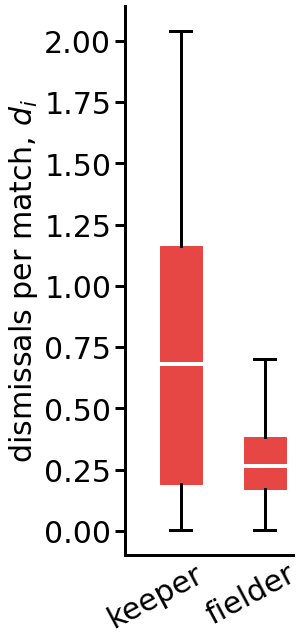

In [10]:
def wicketkeepers_plot(min_career, norm_quant):

    with open(generated_dat_path + f'wicketkeepers_career_data_min_career_{min_career}_renorm_{norm_quant}.pkl', 'rb') as f:
        wicketkeepers_data, fielders_data = pickle.load(f)

    fig, ax = plt.subplots(1,1, figsize=(4, 9))

    ax.boxplot([wicketkeepers_data, fielders_data], positions=[2,5], widths=1.5, 
               patch_artist=True, showfliers=False, boxprops=dict(facecolor='#E64644', color='#E64644'), 
               medianprops=dict(color='white', linewidth=4), 
               whiskerprops=dict(color='black', linewidth=3), 
               capprops=dict(color='black', linewidth=3))
    
    # ax.violinplot([wicketkeepers_data, fielders_data], positions=[2,5], widths=1.5, showmedians=True)

    axis_decor(ax, text_font, 10, 5, 3)
    ax.tick_params(axis='x', which='major', labelsize=text_font, length=0, width=0)
    ax.set_xticks([1.1,4.5],['keeper', 'fielder'], fontsize=text_font, rotation=28, ha='center')
    ax.set_xlim(0,6)
    ax.set_ylabel(rf'dismissals per match, $d_i$', fontsize=text_font)

    print(np.nanmean(wicketkeepers_data), np.nanmean(fielders_data))
    

    plt.tight_layout()
    plt.savefig(fig_path + f'wicketkeepers_career_data_min_career_{min_career}_renorm_{norm_quant}.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()

# wicketkeepers_plot(min_career=25, norm_quant='Runs')

In [30]:
def openers_example(norm_quant, min_career, pos_min_threshold):


    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    players_list = odi_final['player_name'].unique()

    for player in tqdm(players_list):
        player_df = odi_final[odi_final['player_name'].str.contains(player)]
        player_df = player_df.reset_index(drop=True)

        if len(player_df) >= min_career:

            openers_ind = np.where(player_df['bat_pos'] < 3)[0]

            if len(openers_ind) > pos_min_threshold:
                str_rate = np.nanmean(player_df.iloc[openers_ind]['renormalized_bat_run']/player_df.iloc[openers_ind]['bat_balls'])*100
                avg = np.nanmean(player_df.iloc[openers_ind]['renormalized_bat_run'])

                if str_rate > 90:
                    print(player, avg, str_rate)

# openers_example(norm_quant='Runs', min_career=25, pos_min_threshold=10)

 32%|███▏      | 932/2882 [00:25<00:52, 37.01it/s]

Shahid Afridi 24.3737908409078 90.53554816003685


 37%|███▋      | 1076/2882 [00:29<00:48, 37.35it/s]

Virender Sehwag 35.66806080947292 93.87669670616187


 42%|████▏     | 1224/2882 [00:33<00:44, 37.03it/s]

Brendon McCullum 30.831518885507496 97.41623355904058


 61%|██████    | 1756/2882 [00:47<00:30, 37.15it/s]

Rizwan Cheema 32.355892137036975 97.42655335780408


 73%|███████▎  | 2116/2882 [00:57<00:20, 38.13it/s]

Sharjeel Khan 29.90080242312373 91.96405585077926


 79%|███████▉  | 2276/2882 [01:01<00:16, 37.63it/s]

Travis Head 44.51760487929745 100.26695062895502


 80%|███████▉  | 2300/2882 [01:02<00:15, 37.85it/s]

Temba Bavuma 57.044132414354415 91.59693951503954


100%|██████████| 2882/2882 [01:17<00:00, 37.14it/s]
